# Sprod de-noising + TISSUE

This notebook contains code for analyzing Sprod de-noised and Sprod similarity graph versions of TISSUE and investigating whether TISSUE performance is impacted by changes in similarity graph or in de-noising.

It involves the outputs of `spatial_conformal_uncertainty_sprod.py` followed by `get_calibration.py` on the osmFISH dataset. Specifically, it uses parameters from `run_conformal_15sprod.slurm`, `run_conformal_15graph.slurm`, and `run_conformal_15sprodgraph.slurm`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle
import os

from TISSUE.tissue.experiments import measure_calibration_error

In [2]:
#### Swap dataset names to real identifiers
dataset_mapper = {"Dataset15graph": "TISSUE\n(Sprod graph)",
                  "Dataset15sprod": "TISSUE\n(Sprod de-noised)",
                  "Dataset15": "TISSUE\n(original)",
                  "Dataset15sprodgraph": "TISSUE\n(Sprod de-noised\n+Sprod graph)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}
####

## Calibration quality evaluation

Compares the calibration performances in the output pickle files of `get_calibration.py` for the osmFISH somatosensory cortex dataset (Dataset15) using the default/original setup, using Sprod de-noised data as input, using the Sprod cell similarity graph instead of the TISSUE spatial graph, and using both Sprod de-noised data and Sprod cell similarity graph.

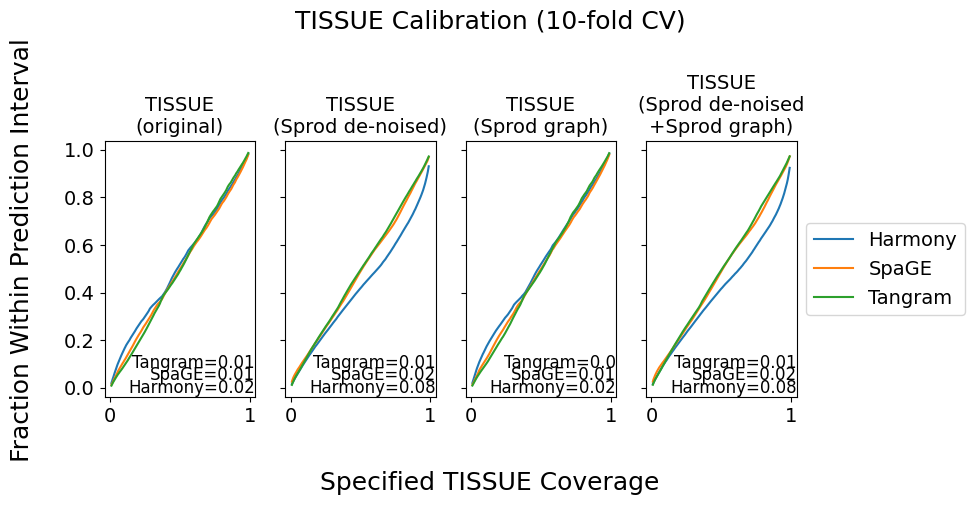

In [3]:
# all in one AVG calibration plot
dataset_names = ["Dataset15", "Dataset15sprod", "Dataset15graph", "Dataset15sprodgraph"]

fig, axs = plt.subplots(nrows=1, ncols=len(dataset_names), sharex=True, sharey=True, figsize=(10, 5))

# loop datasets
for i, dataset_name in enumerate(dataset_names):
    
    # load in results from pickle file
    pickleFile = open("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+dataset_name+"_conformal_dict.pkl", 'rb')
    res_dict = pickle.load(pickleFile)
    
    # draw calibration curve and compute calibration error
    for ki, key in enumerate(res_dict.keys()):
        axs[i].plot(res_dict[key]['1-alpha'], res_dict[key]['test'], linewidth=1.5, label=method_mapper[key])
        error = round(measure_calibration_error(res_dict, key),2)
        axs[i].annotate(method_mapper[key]+"="+str(error), xy=(1, 0+(ki*0.05)), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
        
    axs[i].set_title(dataset_mapper[dataset_name], fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].tick_params(axis='both', which='minor', labelsize=14)

# annotate plot
fig.suptitle("TISSUE Calibration (10-fold CV)", fontsize=18)
fig.supxlabel("Specified TISSUE Coverage", fontsize=18)
fig.supylabel("Fraction Within Prediction Interval", fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_calibration/SPROD_paneled_AVG_calibration_curves.pdf')
plt.show()

## Comparing prediction interval width with and without Sprod

Uses the output anndata objects from `spatial_conformal_uncertainty.py` and `spatial_conformal_uncertainty_sprod.py` (both then followed by `get_calibration.py`) and compares the TISSUE prediction intervals from any of the original or Sprod-based setups.

In [4]:
pi_width = 67
methods = ['knn', 'spage', 'tangram']
datasets = ["Dataset15", "Dataset15sprod", "Dataset15graph", "Dataset15sprodgraph"]

#-------------------------------------------------------------------------------------
all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

for d in datasets:
    
    # loads results anndata
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
    
    if adata.shape[0] > 1000: # sample down to 1000 cells if too large
        np.random.seed(444)
        adata = adata[np.random.choice(adata.obs_names,1000,replace=False),:].copy()
    if adata.shape[1] > 300: # sample down to 300 genes if too large
        np.random.seed(444)
        adata = adata[:,np.random.choice(adata.var_names,300,replace=False)].copy()
    
    # compute stacked bandwidth matrices and stacked prediction matrices
    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    genes = adata.var_names
    
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"][genes].values)
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"][genes].values)
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"][genes].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"][genes].values-adata[:,genes].X))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"][genes].shape, method))
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])

In [5]:
# compile dataframe from results
df = pd.DataFrame([])
df["Dataset"] = [dataset_mapper[x] for x in all_datasets]
df["Method"] = [method_mapper[x] for x in all_models]
df["Log1p PI Width"] = np.log1p(all_uppers-all_lowers)

df = df[df["Dataset"].isin([dataset_mapper["Dataset15"],
                            dataset_mapper["Dataset15sprod"]])]

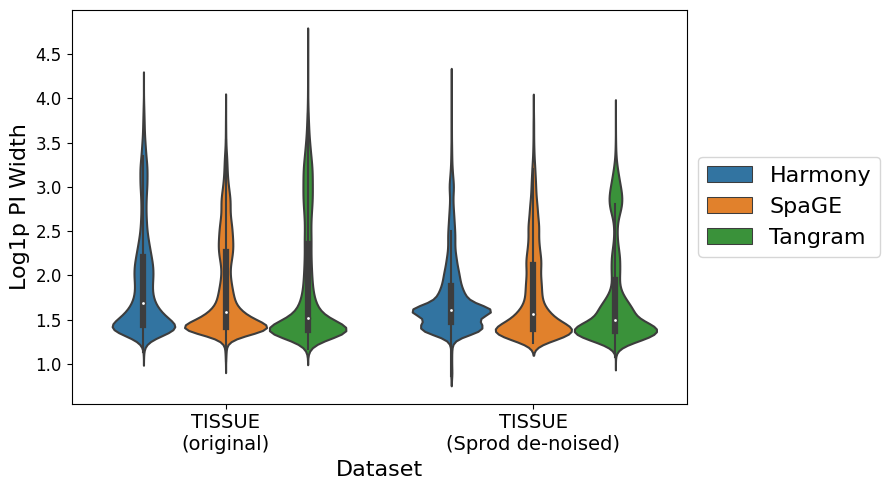

In [6]:
# Make plot of the prediction interval widths across prediction models and setups
plt.figure(figsize=(9,5))
sns.violinplot(x="Dataset", y="Log1p PI Width", hue="Method", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Log1p PI Width", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, ncol=1)
plt.tight_layout()
plt.savefig('plots/scpi_calibration/violin_piwidth_sprod.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Correlating prediction intervals between TISSUE and Sprod spatial network choices

Uses the outputs from the previous sections to compare prediction interval widths across the original setup and the setup where the Sprod cell similarity graph is used instead of the TISSUE spatial graph.

In [7]:
# compile dataframe for plotting
df = pd.DataFrame([])
df["Dataset"] = [dataset_mapper[x] for x in all_datasets]
df["Method"] = [method_mapper[x] for x in all_models]
df["Log1p PI Width"] = np.log1p(all_uppers-all_lowers)

df = df[df["Dataset"].isin([dataset_mapper["Dataset15"],
                            dataset_mapper["Dataset15graph"]])]

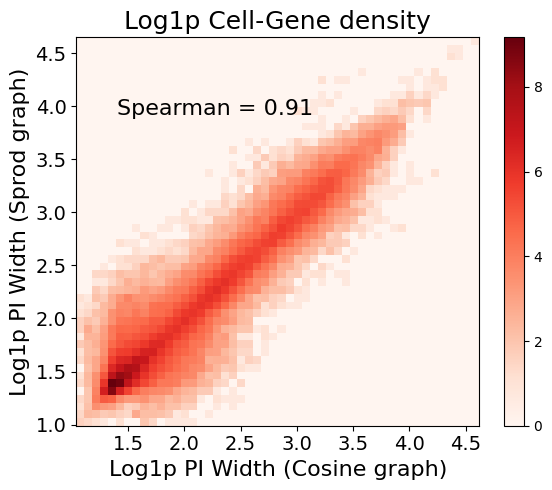

In [8]:
# get x and y values for plot
x = df[df["Dataset"]==dataset_mapper["Dataset15"]]["Log1p PI Width"]
y = df[df["Dataset"]==dataset_mapper["Dataset15graph"]]["Log1p PI Width"]

rho, p = spearmanr(x,y)

# make plot
plt.figure(figsize=(6,5))
heatmap, xedges, yedges = np.histogram2d(x,y,bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.title("Log1p Cell-Gene density",fontsize=18)
plt.xlabel("Log1p PI Width (Cosine graph)", fontsize=16)
plt.ylabel("Log1p PI Width (Sprod graph)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'plots/scpi_calibration/SPROD_graph_PI_correlation.pdf', dpi=300, bbox_inches='tight')
plt.show()